In [1]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

C:\Users\abhi\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


You have TensorFlow version 1.4.0


In [3]:
data = pd.read_csv("stack-overflow-data.csv")

In [5]:
data.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


In [9]:
# Confirm that we have a balanced dataset
# Note: data was randomly shuffled in our BigQuery query
data['tags'].value_counts()

python           2000
iphone           2000
ios              2000
objective-c      2000
.net             2000
css              2000
javascript       2000
java             2000
sql              2000
jquery           2000
c#               2000
html             2000
c++              2000
android          2000
mysql            2000
asp.net          2000
ruby-on-rails    2000
angularjs        2000
c                2000
php              2000
Name: tags, dtype: int64

In [7]:
# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 32000
Test size: 8000


In [10]:
train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

In [11]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [12]:
tokenize.fit_on_texts(train_posts)
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [13]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [14]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [15]:

# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (32000, 1000)
x_test shape: (8000, 1000)
y_train shape: (32000, 20)
y_test shape: (8000, 20)


In [16]:
# You can try tweaking these hyperparamaters
batch_size = 32
epochs = 2

In [17]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
# model.fit trains the model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 28800 samples, validate on 3200 samples
Epoch 1/2
28800/28800 [==============================] - 28s - loss: 0.9711 - acc: 0.7193 - val_loss: 0.6140 - val_acc: 0.8125
Epoch 2/2
28800/28800 [==============================] - 26s - loss: 0.5515 - acc: 0.8224 - val_loss: 0.5858 - val_acc: 0.8169


In [19]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

7808/8000 [============================>.] - ETA: 0sTest score: 0.588881947517395
Test accuracy: 0.8085


In [20]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

jquery( tr_selector ) is removing the style values ...
Actual label:jquery
Predicted label: jquery

web reference in wcf  in wcf if we use webreferenc ...
Actual label:.net
Predicted label: .net

fragment transaction custom animation - android  i ...
Actual label:android
Predicted label: android

why can i not use the namespace directive in c++ s ...
Actual label:c++
Predicted label: c++

generating password reset link in c# .net  i must  ...
Actual label:.net
Predicted label: c#

php 5.3 $this versus php 5.4  i am calling a membe ...
Actual label:php
Predicted label: php

undefined method `request_uri  actiondispatch  i w ...
Actual label:ruby-on-rails
Predicted label: ruby-on-rails

my table view is not showing data  i am using a ta ...
Actual label:iphone
Predicted label: iphone

update panel not working correctly   i have added  ...
Actual label:asp.net
Predicted label: asp.net

floating objects in html  is it possible to make a ...
Actual label:html
Predicted label: html



In [21]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [22]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

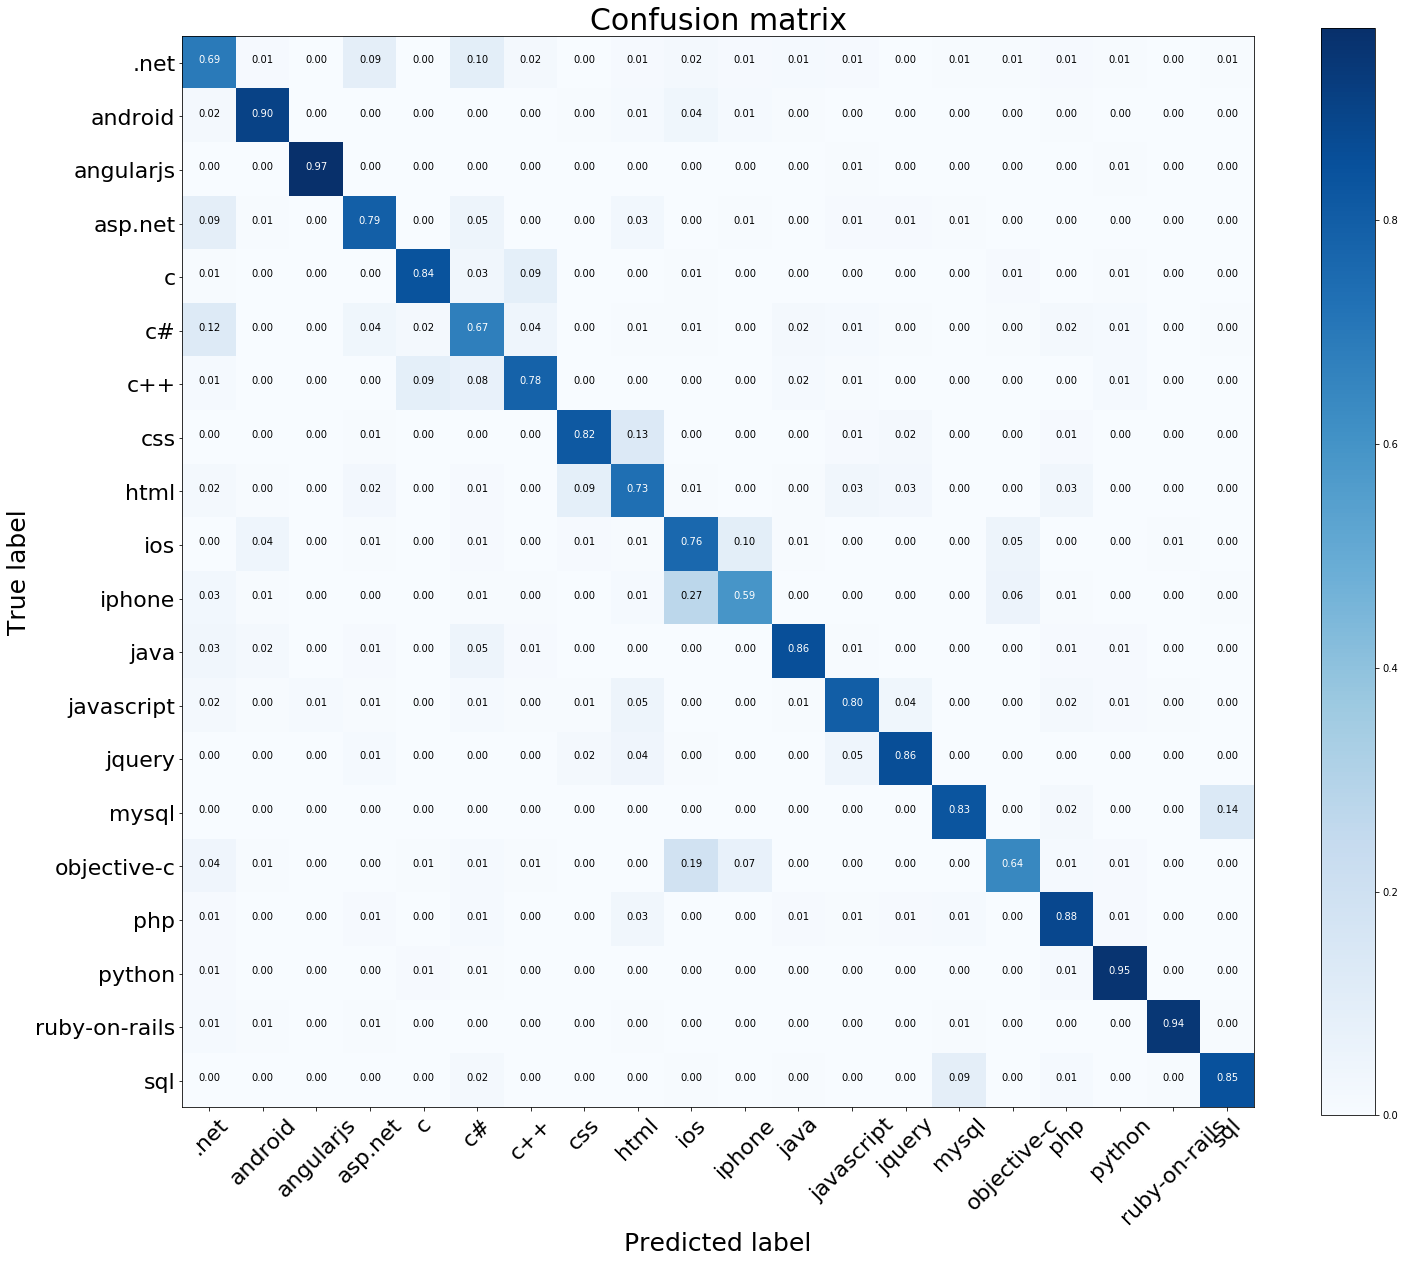

In [23]:

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()